# Showcase I: Creating coverage tiler + Output Visualization in an interactive map

<div class="alert alert-block alert-info">  
<font size=3.5><strong>Section 1: </strong><br>Create a new python module that will allow creating vector tiles based on a specific tile size (e.g 800000x800000).</font> 
<img src="https://github.com/jfbourgon/nrcan-datacube/raw/master/work-modules/images/coverage_tile_example.png">
</div>

## Step 1:

<div class="alert alert-block alert-success">
Import Modules:
<li>fiona: read and write reads and writes spatial data files</li>
<li>shapely: manipulation and analysis of planar geometric objects</li>
<li>geopandas: spatial operations on geometric types</li>
<li>pyproj: cartographic projections and coordinate transformations</li>
<li>ipyleaflet: create interactive maps</li>
</div>

In [1]:
import fiona
import fiona.crs
import shapely
from shapely.geometry import Polygon, shape, box, mapping
import math
import pyproj
from shapely.ops import transform
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import *

## Step 2:
<div class="alert alert-block alert-success">
Define the tile size and load canada.geojson file as an existing coverage
</div>

In [9]:
tile_size = 800000

# Load canada.geojson file with fiona
source = fiona.open('../presentation/canada.geojson')
canada = shape(source[0]["geometry"])

## Step 3
<div class="alert alert-block alert-success">
Create a custom index based on a specific tile size over the existing coverage (canada.geojson)
</div>

In [3]:
container = []
range_minx = math.floor(source.bounds[0]/tile_size)
range_maxx = math.ceil(source.bounds[2]/tile_size)
range_miny = math.floor(source.bounds[1]/tile_size)
range_maxy = math.ceil(source.bounds[3]/tile_size)
for i in range(range_minx,range_maxx):
    x = i * tile_size
    for j in range(range_miny,range_maxy):
        y = j * tile_size
        my_tile = box(x,y,x+tile_size,y+tile_size)
        if my_tile.intersects(canada):
            container.append(my_tile)
print(container)

[<shapely.geometry.polygon.Polygon object at 0x000001BBE959E1F0>, <shapely.geometry.polygon.Polygon object at 0x000001BBE959E220>, <shapely.geometry.polygon.Polygon object at 0x000001BBE9597FA0>, <shapely.geometry.polygon.Polygon object at 0x000001BBED0542B0>, <shapely.geometry.polygon.Polygon object at 0x000001BBED054250>, <shapely.geometry.polygon.Polygon object at 0x000001BBED054280>, <shapely.geometry.polygon.Polygon object at 0x000001BBED054340>, <shapely.geometry.polygon.Polygon object at 0x000001BBED0543A0>, <shapely.geometry.polygon.Polygon object at 0x000001BBED054490>, <shapely.geometry.polygon.Polygon object at 0x000001BBED054430>, <shapely.geometry.polygon.Polygon object at 0x000001BBED057AF0>, <shapely.geometry.polygon.Polygon object at 0x000001BBED057490>, <shapely.geometry.polygon.Polygon object at 0x000001BBED057430>, <shapely.geometry.polygon.Polygon object at 0x000001BBED0573D0>, <shapely.geometry.polygon.Polygon object at 0x000001BBED0574C0>, <shapely.geometry.polygo

## Step 4
<div class="alert alert-block alert-success">
Write the custom index into a geojson file
</div>

In [4]:
# create a schema for the new geojson file
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# use fiona to create an output file 
with fiona.open ('tiler_{}.geojson'.format(tile_size),
                 'w','GeoJSON',schema, 
                 crs=fiona.crs.from_epsg(3979)) as output:  
    index = 0
    for i in container:
        index += 1
        output.write({
            'geometry': mapping(i),
            'properties': {'id': index}})
output.close()

## Step 5
<div class="alert alert-block alert-success">
Visualize the output tilings
</div>

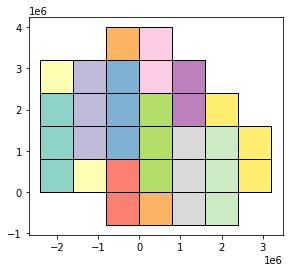

In [4]:
tile_geom = [shape(i) for i in container]
#print(tile_geom)
tile_gdf = gpd.GeoDataFrame({'geometry':tile_geom})
#print(tile_gdf)

ax = tile_gdf.plot(cmap='Set3')
#coverage_gdf.plot(ax=ax, facecolor='none', edgecolor='k');
tile_gdf.plot(ax=ax, facecolor='none', edgecolor='k');

## Step 6
<div class="alert alert-block alert-success">
Reproject the tilings to the same coordinate system of basemap and convert it into a geodataframe
</div>

In [6]:
# Read proposed tiling (output of your first script)
tiles = fiona.open('../presentation/tiler_{}.geojson'.format(tile_size))

# reproject the tiling to adapt the coordinate system of basemap
df_tiles = []
for i in range(1,len(tiles)+1):
    tile = shape(tiles[i]['geometry'])
    project = pyproj.Transformer.from_proj(pyproj.Proj(tiles.crs['init']), # source coordinate system
                                           pyproj.Proj('epsg:4326'),
                                           always_xy=True) # destination coordinate system
    proj_tile = transform(project.transform, tile)  # apply projection
    df_tiles.append(proj_tile)

# Generate GeoData layer from the geodataframe   
tiler_geom = [shape(i) for i in df_tiles]
tiler_gdf = gpd.GeoDataFrame({'geometry':tiler_geom})
data = GeoData(geo_dataframe = tiler_gdf, name = 'Poly')

## Step 7
<div class="alert alert-block alert-success">
Show the tilings in an interactive map using ipyleaflet
</div>

In [7]:
# Add layer to map
m = Map(center=(70.1304,-106.3468), zoom=2, crs=projections.EPSG3857, basemap=basemaps.Esri.WorldTopoMap)
m.add_layer(data)

m

Map(center=[70.1304, -106.3468], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…